In the document entitled **a first glance**, I tried to re-discover some correlations between *doctor's office waiting time* and *race/ethnicity*. Although I didn't do any statistics (yet), it looked like there was a relationship between the variables. 

Today I'm going to see how race/ethnicity correlate to the `ACC_USHURRY` or `ACC_USEXPPRB` or `ACC_USDISCUS` variables, which represent "Doctor seems to be in a hurry," "Doctor doesn't explain medical problems," and "[Health problems should] be discussed but are not."

The values are encoded in this way:

     .='Missing'
     1='1:Strongly Agree'
     2='2:Agree'
     3='3:Disagree'
     4='4:Strongly Disagree'
     5='5:No experience'
    -7='-7:Refused'
    -8="-8:Don't know"
    -9='-9:Not ascertained'

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

%matplotlib inline

In [2]:
mcbs_datafile = os.path.join(os.getcwd(), '..', 'data', 'ATCPUF13.csv')
df = pd.read_csv(mcbs_datafile)

# create race dict for conversion
racefmt = {1:'White',
           2:'Black',
           3:'Hispanic',
           4:'Other'}


race = df.IV_RACE.replace(racefmt)

# we only keep values 1-4 for the "agree" format
hurry = df.ACC_USHURRY
explain = df.ACC_USEXPPRB
discuss =df.ACC_USDISCUS

# construct access-to-care DataFrame
access_df = pd.DataFrame({'race': race,
                          'hurry': hurry,
                          'explain': explain,
                          'discuss': discuss})

In [3]:
# clean out all values where discuss/explain/hurry are not 1-4
access_df = access_df[((access_df.hurry <= 4) & (access_df.hurry >= 1)) &
                      ((access_df.explain <= 4) & (access_df.explain >= 1)) &
                      ((access_df.discuss <= 4) & (access_df.discuss >= 1))]

print(access_df.sample(10))

       discuss  explain  hurry      race
5131       4.0      4.0    4.0  Hispanic
938        3.0      3.0    3.0     White
1498       4.0      4.0    4.0  Hispanic
6742       3.0      3.0    3.0  Hispanic
2869       3.0      3.0    3.0     White
9393       3.0      3.0    3.0     White
10221      4.0      3.0    3.0     White
13683      4.0      4.0    4.0     White
10426      3.0      3.0    3.0     White
12062      4.0      4.0    4.0     White


In [4]:
grouped_access = access_df.groupby('race')
grouped_access.aggregate(np.mean)

,discuss,explain,hurry
race,,,
Black,3.075277,3.069373,3.061993
Hispanic,3.075488,3.084369,3.043517
Other,3.073136,3.119550,3.016878
White,3.171677,3.173059,3.083502


Note: higher is better.

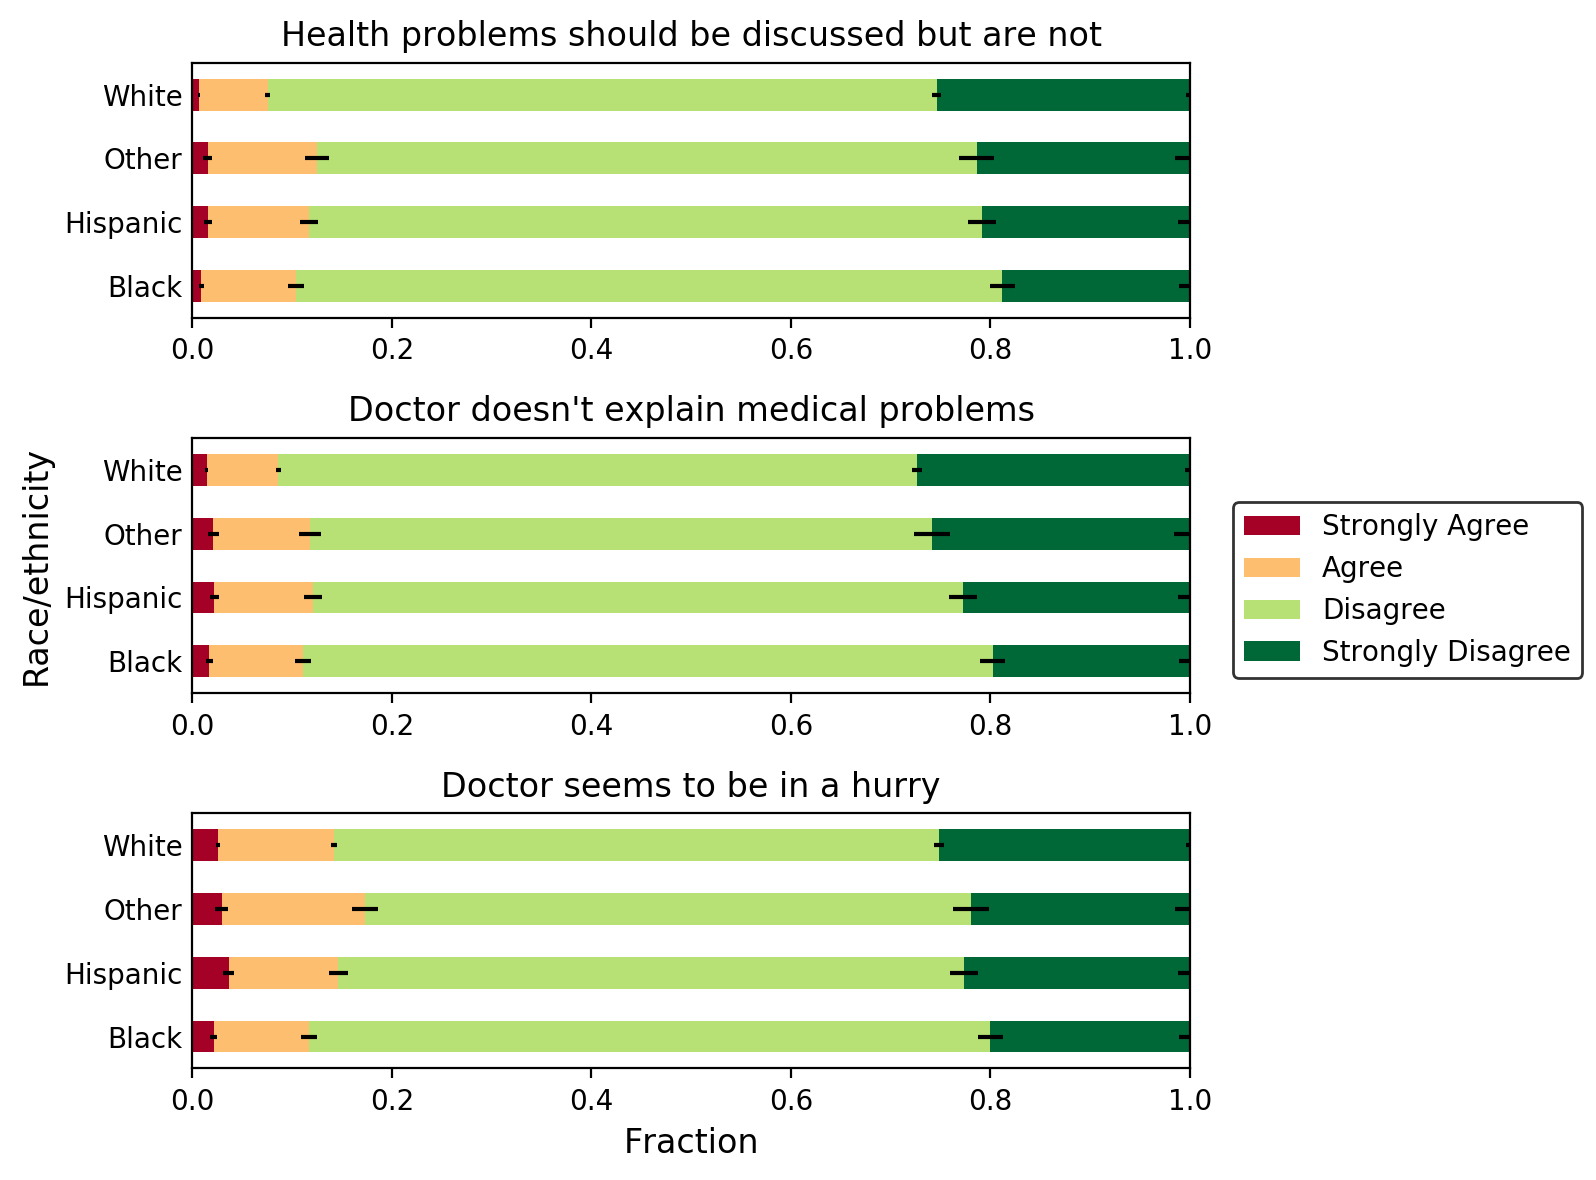

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6), dpi=200, sharex=False)

questions_fmt = {'hurry': "Doctor seems to be in a hurry",
                 'explain': "Doctor doesn't explain medical problems",
                 'discuss': "Health problems should be discussed but are not"}

for ax, cat in zip(axes, ['discuss', 'explain', 'hurry']):
    subset_df = access_df.groupby(['race', cat]).size().unstack().sort_index()
    subset_uncertainties = subset_df.apply(lambda x: np.sqrt(x * (x.sum() - x) / (x.sum())**3), axis=1)
    subset_df.apply(lambda x: x / x.sum(), axis=1).plot.barh(ax=ax, xerr=subset_uncertainties, 
                                                             colormap='RdYlGn', stacked=True, legend=False)
    
    ax.tick_params(axis='y', length=0)
    ax.set_title(questions_fmt[cat])
    ax.set_xlim(0, 1.0)
    ax.set_ylabel('')
    
axes[1].set_ylabel('Race/ethnicity', fontsize=12)
axes[2].set_xlabel('Fraction', fontsize=12)

fig.tight_layout()
fig.subplots_adjust(right=0.75)

# change legend format
agree_fmt = {1: 'Strongly Agree',
             2: 'Agree',
             3: 'Disagree',
             4: 'Strongly Disagree'}

handles, labels = ax.get_legend_handles_labels()
new_labels = [agree_fmt[int(z[0])] for z in labels]

legend = fig.legend(handles, new_labels, loc='center right')
legend.set_alpha(1.0)
legend.get_frame().set_edgecolor('black')